# Annex 96 Common Exercise 1 – Quick Start Notebook

This notebook provides a minimal end-to-end setup for:


1. Cloning the CE1 GitHub repository
2. Understanding the TX & VT datasets
3. Visualizing the daily reference district load
4. Running a simple baseline battery RBC controller
5. Evaluating KPIs

If you run into issues, please reach out on the Annex 96 Slack (Common Exercise channel).


# 1. Install Required Dependencies

This Common Exercise uses a **specific version of CityLearn included inside this repository**.

👉 **Do NOT install CityLearn using `pip install citylearn`.**  
This will install a different version that is **not compatible** with the Common Exercise and will cause errors.

Instead, please install all dependencies directly from the repository’s `requirements.txt` file.





### Clone the Common Exercise repository


In [ ]:
!git clone https://github.com/kkaspar10/annex96_common_exercise_1.git

### Install required Python packages

In [2]:
!pip install -U ipykernel

In [20]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


## 2. Dataset Overview (TX vs VT)

The Common Exercise uses two scenarios:

### 🔵 Texas (TX) – cooling dominated  
- Training: **June**  
- Testing: **July**  
- Higher solar generation, strong cooling loads.

### 🔵 Vermont (VT) – heating dominated  
- Training: **January**  
- Testing: **February**  
- High heating loads, low PV in winter.

Each climate folder contains:

- `schema.json`  
- 25 ResStock buildings  
- Pre-computed district reference load  
- All data handled automatically by CityLearn




In [16]:
from pathlib import Path
import os

# Where the notebook actually lives
NOTEBOOK_DIR = Path(os.getcwd())
print("Notebook directory:", NOTEBOOK_DIR)

# Go one level up to the repo root
BASE_DIR = NOTEBOOK_DIR.parent
print("Repository root:", BASE_DIR)

# Choose climate: TX or VT
CLIMATE = "VT"  # or "VT"

DATASET_DIR = BASE_DIR / "data" / "datasets" / f"annex96_ce1_{CLIMATE.lower()}_neighborhood"
SCHEMA_PATH = DATASET_DIR / "schema.json"

print("\nClimate:", CLIMATE)
print("Dataset directory:", DATASET_DIR, " | exists:", DATASET_DIR.exists())
print("Schema path:", SCHEMA_PATH, " | exists:", SCHEMA_PATH.exists())


Notebook directory: c:\Users\sabry\Documents\annex96_common_exercise_1\notebooks
Repository root: c:\Users\sabry\Documents\annex96_common_exercise_1

Climate: VT
Dataset directory: c:\Users\sabry\Documents\annex96_common_exercise_1\data\datasets\annex96_ce1_vt_neighborhood  | exists: True
Schema path: c:\Users\sabry\Documents\annex96_common_exercise_1\data\datasets\annex96_ce1_vt_neighborhood\schema.json  | exists: True


## 3. District Load Target

Each day, the Annex 96 CE defines a **constant district load target** equal to the average aggregated demand of all buildings for the each day.

Controllers attempt to track this reference profile.

Below is the reference load plot for the selected climate (TX or VT).

![District Target](../assets/images/district_load_target.png)



In [17]:
import pandas as pd

district_target_df = pd.read_csv(DATASET_DIR / "district_target.csv")
district_target = district_target_df["district_load_target"].values

## 4. Run a Simple Battery RBC Controller

This baseline:

- Uses the built-in `BasicRBC` controller  
- Controls all buildings through a **central agent**  
- Produces reference KPIs to compare against learning-based methods  


In [ ]:
# === Notebook cell: CityLearn local outside working directory ===
import sys
from pathlib import Path
import importlib
import traceback
import os

# --- 1) set main paths (modify according to your structure) ---
NOTEBOOK_ROOT = Path.cwd()  # working directory of the notebook
print("Working directory:", NOTEBOOK_ROOT)

# Parent folder containing the 'citylearn' package
CITYLEARN_PATH = Path("../")   # adjust if citylearn is in a different location
sys.path.insert(0, str(CITYLEARN_PATH))
print("Added citylearn path to sys.path:", CITYLEARN_PATH)

name = 'tx'
# Folder containing dataset / data
DATASET_DIR = Path(f"../data/datasets/annex96_ce1_{name}_neighborhood")  # modify according to your dataset

# Try to automatically find a schema.json under DATASET_DIR
SCHEMA_PATH = None
if DATASET_DIR.exists():
    for candidate in DATASET_DIR.rglob("schema.json"):
        SCHEMA_PATH = candidate
        break

# Fallback: search for schema.json in the notebook root
if SCHEMA_PATH is None:
    for candidate in NOTEBOOK_ROOT.rglob("schema.json"):
        SCHEMA_PATH = candidate
        break

if SCHEMA_PATH is None:
    raise FileNotFoundError("schema.json not found automatically. Please set SCHEMA_PATH manually.")

print("DATASET_DIR:", DATASET_DIR if DATASET_DIR.exists() else "(not found)")
print("SCHEMA_PATH:", SCHEMA_PATH)

# --- 2) import CityLearnEnv ---
try:
    from citylearn.citylearn import CityLearnEnv
    print("CityLearnEnv import OK")
except Exception as e:
    print("Error importing CityLearn. Traceback:")
    traceback.print_exc()
    raise ImportError("Cannot import 'citylearn' from the local folder.")

# --- 3) initialize the CityLearn environment ---
try:
    env = CityLearnEnv(schema=str(SCHEMA_PATH), root_directory=str(DATASET_DIR), central_agent=True)
except TypeError as e:
    print("TypeError in CityLearnEnv init:", e)
    print("Trying to create env passing only the schema (version compatibility)...")
    env = CityLearnEnv(schema=str(SCHEMA_PATH), central_agent=True)

# --- 4) reset the environment (Gym/Gymnasium compatible) ---
reset_ret = env.reset()
if isinstance(reset_ret, tuple):
    observations = reset_ret[0]
    info = reset_ret[1] if len(reset_ret) > 1 else {}
else:
    observations = reset_ret
    info = {}

# --- 5) diagnostic prints ---
print("\n--- CityLearn Diagnostics ---")
print("Number of buildings:", len(getattr(env, "buildings", [])))
if hasattr(env, "action_names") and env.action_names:
    print("Action names (first 10 of first building):", env.action_names[0][:10])
else:
    print("action_names not available or empty.")

if hasattr(env, "observation_names") and env.observation_names:
    print("Observation names (first 15 of first building):", env.observation_names[0][:15])
else:
    print("observation_names not available or empty.")

print("Type of observations:", type(observations))
try:
    if isinstance(observations, (list, tuple)) and len(observations) > 0:
        print("Observation preview (first 2 elements of first building):", observations[0][:2])
except Exception:
    pass

print("ENV initialized successfully ✅")



Working directory: c:\Users\sabry\Documents\annex96_common_exercise_1\notebooks
DATASET_DIR: ..\data\datasets\annex96_ce1_tx_neighborhood
SCHEMA_PATH: ..\data\datasets\annex96_ce1_tx_neighborhood\schema.json

--- Diagnostica CityLearn ---
Numero edifici: 25
Action names (primi 10 del primo edificio): ['cooling_device', 'cooling_device', 'cooling_device', 'cooling_device', 'cooling_device', 'cooling_device', 'cooling_device', 'cooling_device', 'cooling_device', 'cooling_device']
Observation names (primi 15 del primo edificio): ['month', 'hour', 'outdoor_dry_bulb_temperature', 'direct_solar_irradiance', 'outdoor_dry_bulb_temperature_predicted_1', 'outdoor_dry_bulb_temperature_predicted_2', 'outdoor_dry_bulb_temperature_predicted_3', 'direct_solar_irradiance_predicted_1', 'direct_solar_irradiance_predicted_2', 'direct_solar_irradiance_predicted_3', 'indoor_dry_bulb_temperature', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand']
Tipo observations: <class 'list'>
Antep

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from citylearn.agents.base import Agent

class ForcedBatteryRBC(Agent):
    """Toy controller: charge 9–12, discharge 16–19 for all electrical_storage actions."""
    def __init__(self, env):
        super().__init__(env)

    def predict(self, observations, deterministic=None):
        # Hour is in the shared observations of the first building
        hour_idx = self.env.observation_names[0].index('hour')
        hour = int(observations[0][hour_idx])

        if 9 <= hour <= 12:
            u = 1.0   # full charge
        elif 16 <= hour <= 19:
            u = -1.0  # full discharge
        else:
            u = 0.0   # idle

        actions = []
        for names in self.action_names:
            acts = []
            for name in names:
                if "electrical_storage" in name:
                    acts.append(u)
                else:
                    acts.append(0.0)
            actions.append(acts)

        self.actions = actions
        self.next_time_step()
        return actions

# --- run the controller ---
env.reset()
controller = ForcedBatteryRBC(env)
district_load_forced = []

obs, info = env.reset()
while not env.terminated:
    acts = controller.predict(obs)
    obs, reward, terminated, truncated, info = env.step(acts)
    district_load_forced.append(env.net_electricity_consumption[-1])

district_load_forced = np.array(district_load_forced)


[WARN] demand is greater than heating_device max output | timestep=0, building=resstock-amy2018-2021-release-1-147002, demand=13.940381050109863, max=11.416627055757761
[WARN] demand is greater than heating_device max output | timestep=0, building=resstock-amy2018-2021-release-1-179247, demand=4.575142860412598, max=3.9311781310600615
[WARN] demand is greater than heating_device max output | timestep=0, building=resstock-amy2018-2021-release-1-199613, demand=12.053640365600586, max=9.294887957087212
[WARN] demand is greater than heating_device max output | timestep=0, building=resstock-amy2018-2021-release-1-20199, demand=21.551294326782227, max=10.113437650863233
[WARN] demand is greater than heating_device max output | timestep=0, building=resstock-amy2018-2021-release-1-216895, demand=4.569467544555664, max=3.4071924942675422
[WARN] demand is greater than heating_device max output | timestep=0, building=resstock-amy2018-2021-release-1-223581, demand=5.57281494140625, max=4.035558496

In [24]:
baseline_district_load = np.array(env.net_electricity_consumption_without_storage)
print(len(baseline_district_load))

744


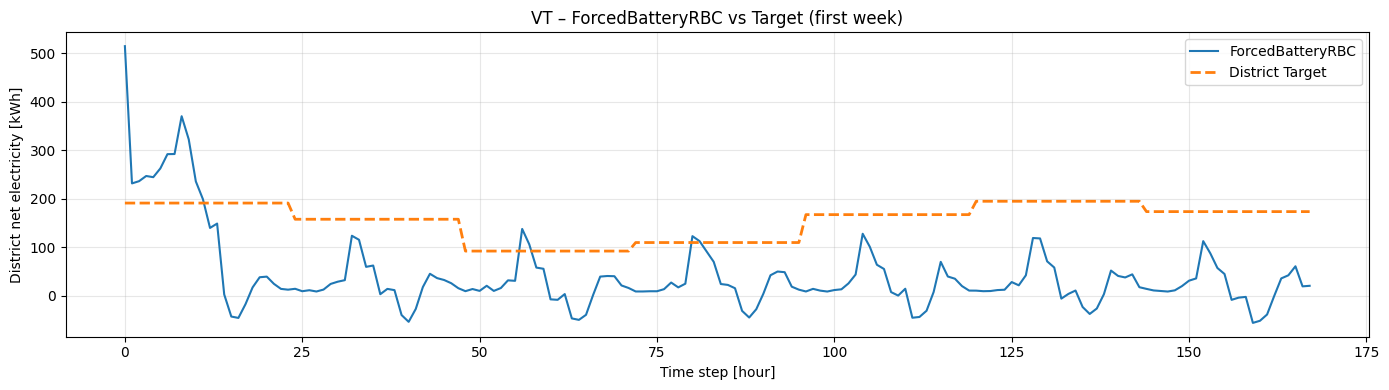

In [35]:
hours = np.arange(168)

plt.figure(figsize=(14,4))
plt.plot(hours, district_load_forced[:168], label='ForcedBatteryRBC')
plt.plot(hours, district_target[:168], '--', label='District Target', linewidth=2)

plt.xlabel("Time step [hour]")
plt.ylabel("District net electricity [kWh]")
plt.title("VT – ForcedBatteryRBC vs Target (first week)")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Evaluate Performance (KPIs)

These KPIs will be used for comparison across all CE1 participants.


In [31]:
kpis = env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis


name,District,resstock-amy2018-2021-release-1-112208,resstock-amy2018-2021-release-1-147002,resstock-amy2018-2021-release-1-179247,resstock-amy2018-2021-release-1-199613,resstock-amy2018-2021-release-1-20199,resstock-amy2018-2021-release-1-216895,resstock-amy2018-2021-release-1-223581,resstock-amy2018-2021-release-1-245723,resstock-amy2018-2021-release-1-247942,...,resstock-amy2018-2021-release-1-4421,resstock-amy2018-2021-release-1-460412,resstock-amy2018-2021-release-1-467125,resstock-amy2018-2021-release-1-481052,resstock-amy2018-2021-release-1-485614,resstock-amy2018-2021-release-1-498771,resstock-amy2018-2021-release-1-525859,resstock-amy2018-2021-release-1-538628,resstock-amy2018-2021-release-1-76701,resstock-amy2018-2021-release-1-88386
cost_function,,,,,,,,,,,,,,,,,,,,,
all_time_peak_average,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_normalized_unserved_energy_total,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
carbon_emissions_total,1.000000,1.000000,1.00000,1.00000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
cost_total,1.000000,1.000000,1.00000,1.00000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
daily_one_minus_load_factor_average,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daily_peak_average,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discomfort_cold_delta_average,0.012839,0.000000,0.00000,0.02317,0.040028,0.0,0.035637,0.004606,0.0,0.033651,...,0.000000,0.018057,0.0,0.043043,0.050179,0.0,0.046524,0.0,0.000000,0.000000
discomfort_cold_delta_maximum,0.012839,0.000000,0.00000,0.02317,0.040028,0.0,0.035637,0.004606,0.0,0.033651,...,0.000000,0.018057,0.0,0.043043,0.050179,0.0,0.046524,0.0,0.000000,0.000000
discomfort_cold_delta_minimum,0.012839,0.000000,0.00000,0.02317,0.040028,0.0,0.035637,0.004606,0.0,0.033651,...,0.000000,0.018057,0.0,0.043043,0.050179,0.0,0.046524,0.0,0.000000,0.000000


## You're all set!

You now have:

- Installed CityLearn requirements 
- Loaded TX or VT scenario  
- Viewed district reference loads  
- Run a baseline RBC  
- Computed comparison KPIs  

If you run into any issue, please reach out in the **Annex 96 Slack**.

Happy experimenting! 🚀
